# LoCoMock (LogP-corrected Membrane Docking)

This program is a modified extension of Jupyter_Dock[https://github.com/AngelRuizMoreno/Jupyter_Dock].

Place this notebook on the "Jupyter_Dock" directory.

In [1]:
from pymol import cmd
import py3Dmol

from vina import Vina

from openbabel import pybel

from rdkit import Chem
from rdkit.Chem import AllChem, Draw, rdCoordGen
from rdkit.ML.Cluster import Butina

import MDAnalysis as mda
from MDAnalysis.coordinates import PDB
from MDAnalysis.analysis import diffusionmap, align, rms

import sys, os
sys.path.insert(1, 'utilities/')
from utils import fix_protein, getbox, generate_ledock_file, pdbqt_to_sdf, dok_to_sdf

import glob

import matplotlib
import matplotlib.pyplot as plt

import numpy as np

import warnings
warnings.filterwarnings("ignore")
%config Completer.use_jedi = False

## Plot Settings

In [2]:
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['font.size'] = 12
matplotlib.rcParams['figure.dpi'] = 300
matplotlib.rcParams['font.family'] = "Helvetica"

matplotlib.rcParams.update({'figure.figsize': [5,4]})

## Project Settings

In [3]:
str_id = "project_id"
n_poses = 200
ligand_smiles = "CO"
membrane_pos = 14.7
buffer = 4.7

In [5]:
os.mkdir(f"LoCoMock/LoCoMock_{str_id}/")
os.chdir(f"LoCoMock/LoCoMock_{str_id}/")

## Prepare Protein

Please predict the orientation and membrane position for your protein at PPM server [https://opm.phar.umich.edu/ppm_server3].


Place the result as "protein.pdb" in the directory "LoCoMock/LoCoMock_project_id".

In [64]:
!../../bin/lepro_linux_x86 {'protein.pdb'}
os.rename('pro.pdb','protein_H.pdb')

## Prepare Ligand

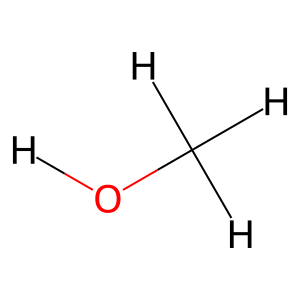

In [65]:
mol_noH = Chem.MolFromSmiles(ligand_smiles)
mol = Chem.AddHs(mol_noH)
Draw.MolToImage(mol)

In [66]:
from rdkit.Chem import Descriptors
Descriptors.MolLogP(mol)

-0.3915

In [67]:
from rdkit.Chem.Draw import SimilarityMaps
from rdkit.Chem import rdMolDescriptors
contribs = rdMolDescriptors._CalcCrippenContribs(mol)
fig = SimilarityMaps.GetSimilarityMapFromWeights(mol,[x for x,y in contribs], colorMap='seismic', contourLines=0, sigma=0.02)
fig
fig.savefig('ligand_logP.png',bbox_inches='tight', dpi=300) 


In [68]:
[print(c,a.GetSymbol()) for c, a in zip(contribs,mol.GetAtoms())]

(-0.2035, 2.753) C
(-0.2893, 0.8238) O
(0.123, 1.057) H
(0.123, 1.057) H
(0.123, 1.057) H
(-0.2677, 1.395) H


[None, None, None, None, None, None]

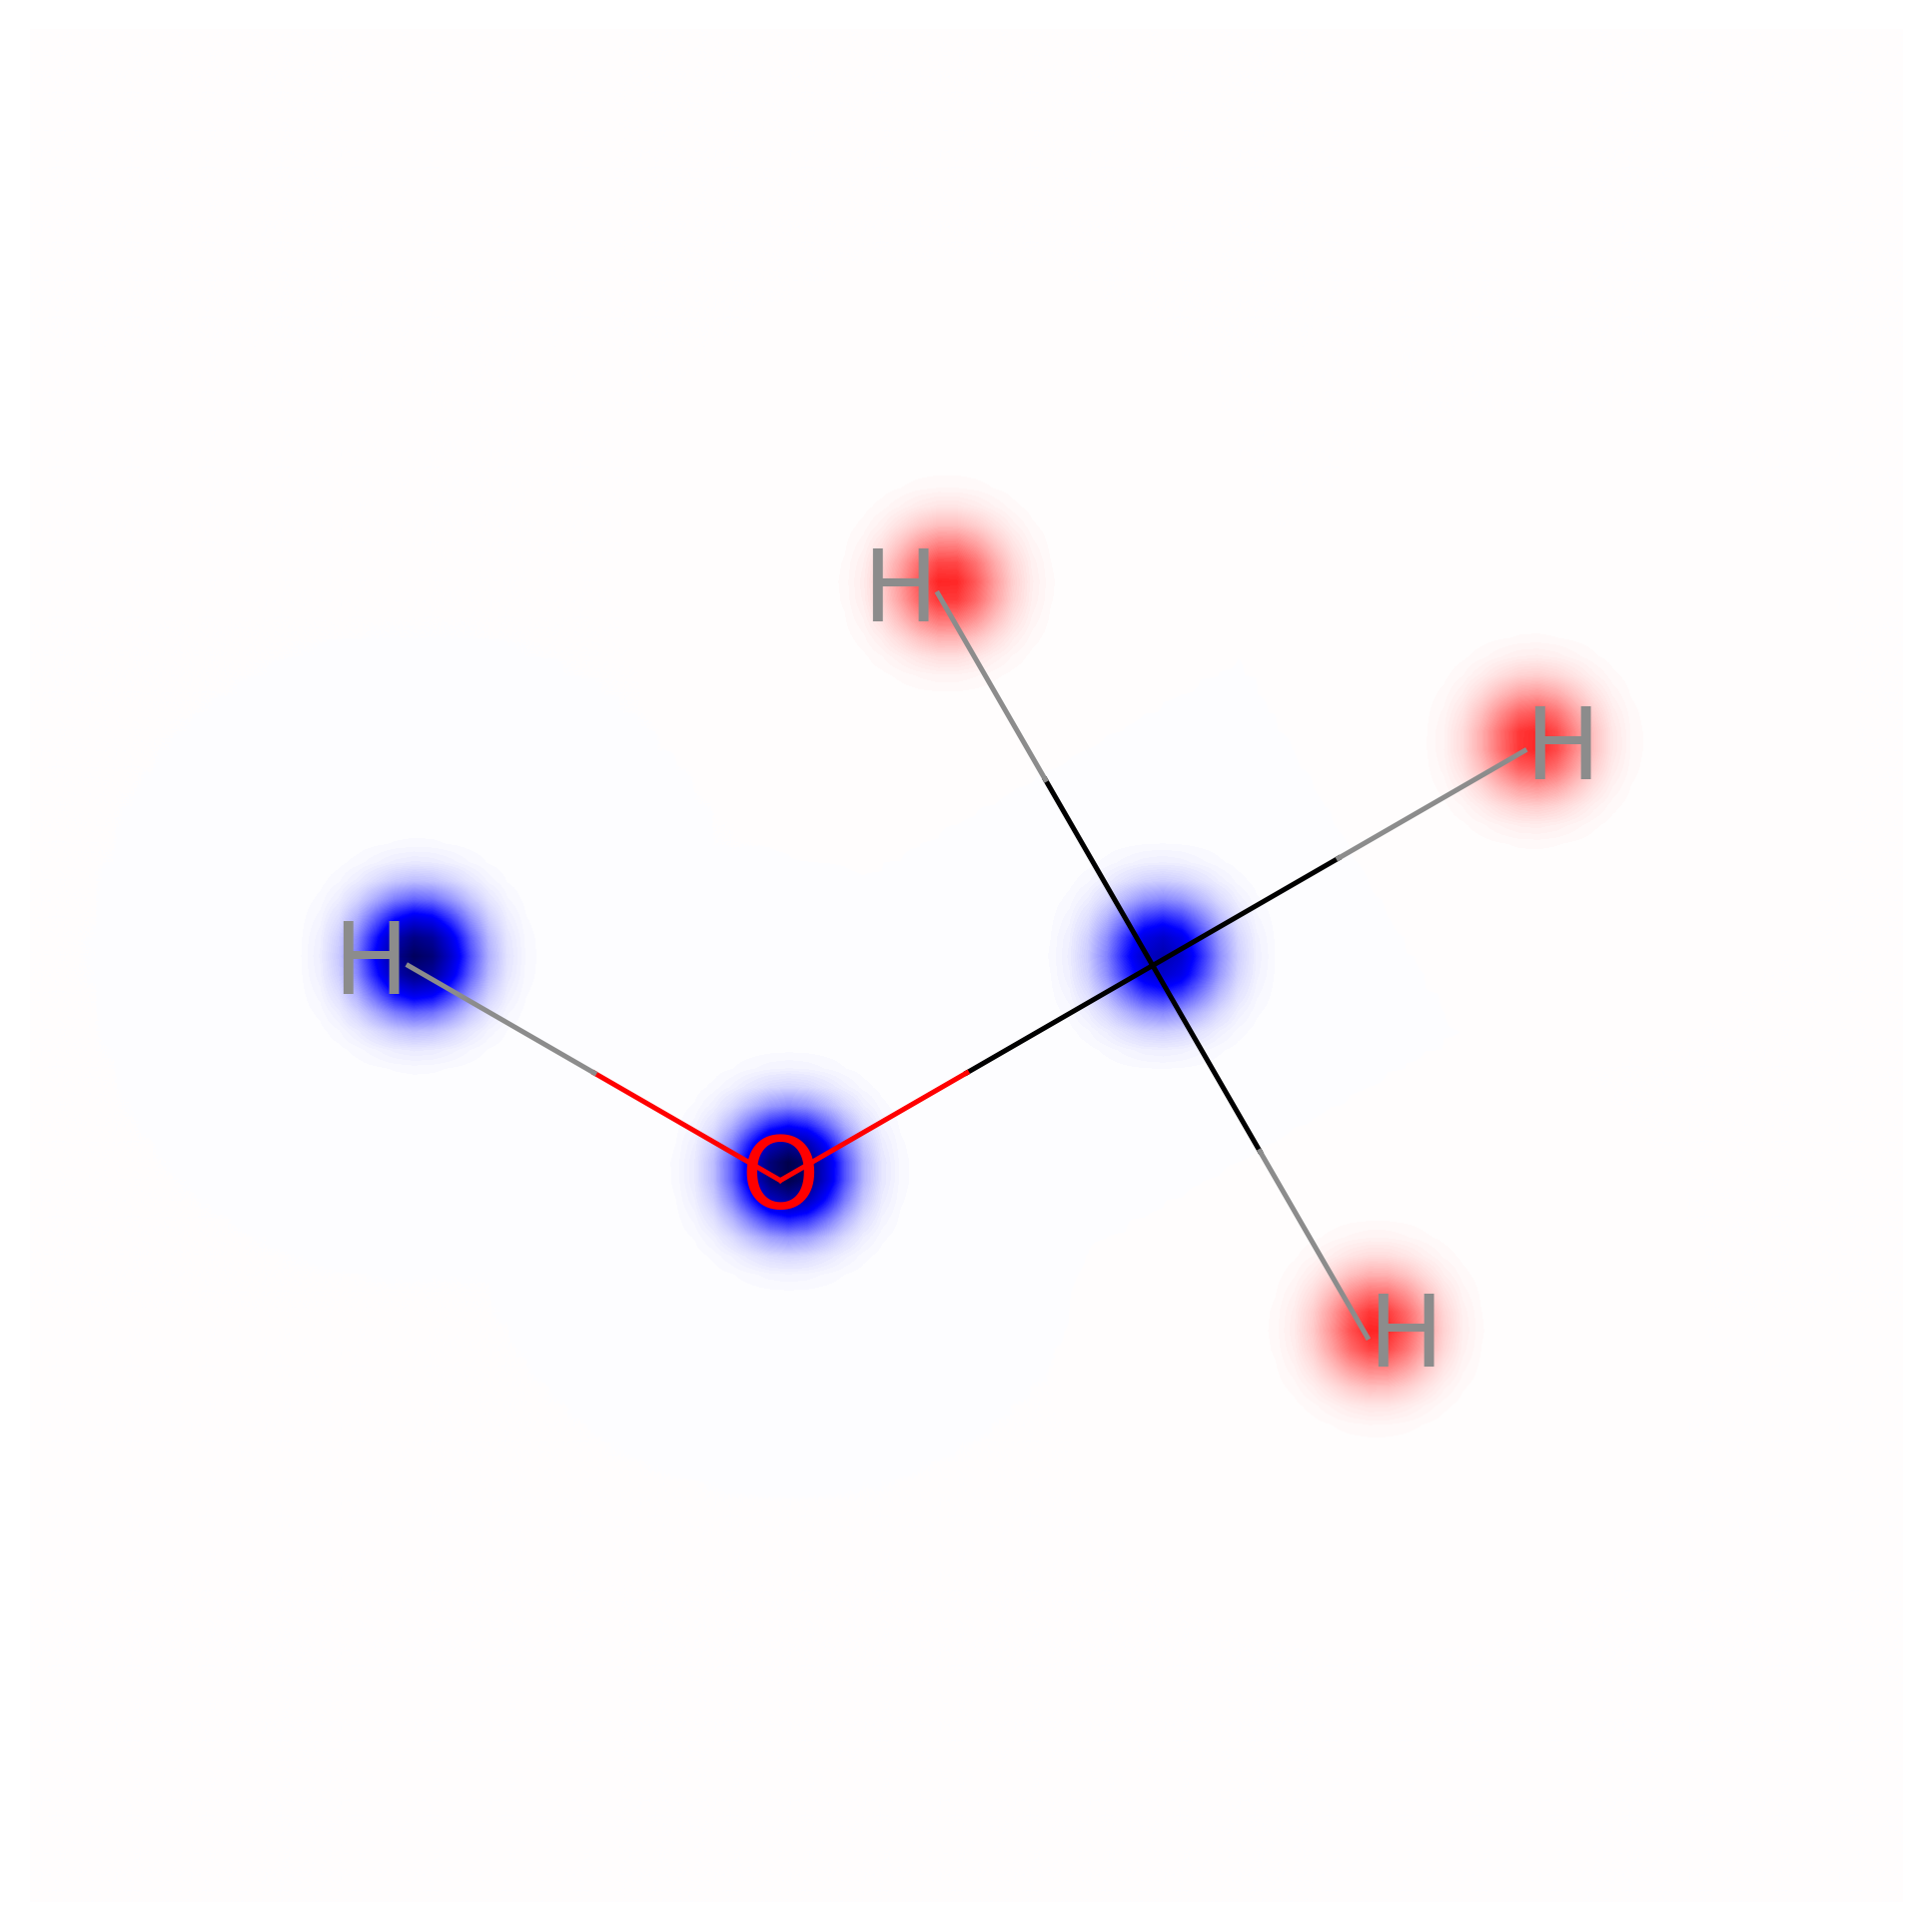

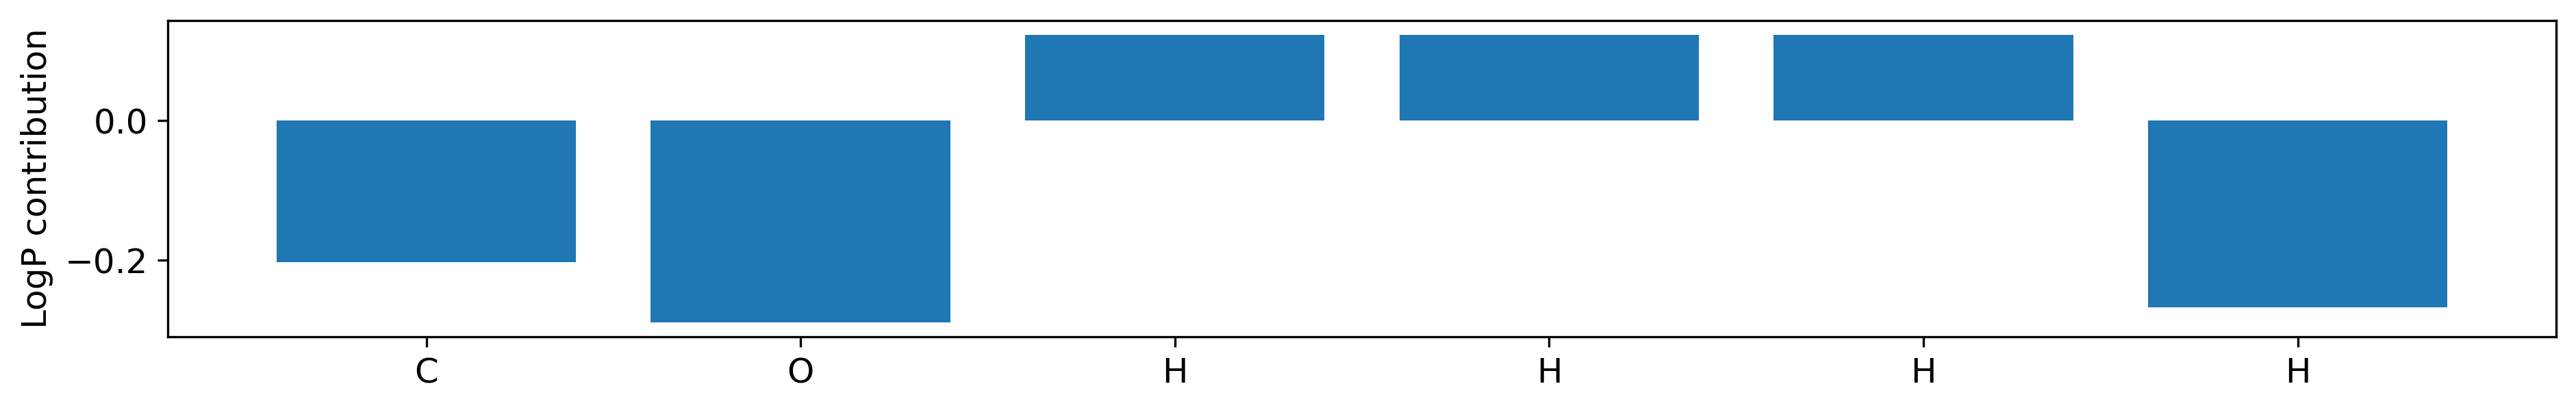

In [69]:
fig = plt.figure(figsize=(15,2))
plt.bar(range(len(contribs)), [x for x,y  in contribs])
plt.xticks(range(len(contribs)),[a.GetSymbol() for a in mol.GetAtoms()])
plt.ylabel("LogP contribution")
plt.show()
plt.show()

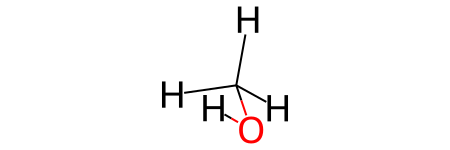

In [70]:
rdCoordGen.AddCoords(mol)
AllChem.EmbedMolecule(mol, useRandomCoords=True)
AllChem.MMFFOptimizeMolecule(mol)
mol

In [71]:
writer = Chem.rdmolfiles.SDWriter("out.sdf")
writer.write(mol)

In [72]:
sdf_mol = pybel.readfile("sdf", "out.sdf")
for index,mol in enumerate(sdf_mol):
    out=pybel.Outputfile(filename='./ligand.mol2', format='mol2',overwrite=True, opt={"h": 7.0})
    out.write(mol)
    out.close()

In [73]:
sdf_mol = pybel.readfile("sdf", "out.sdf")
for index,mol in enumerate(sdf_mol):
    out=pybel.Outputfile(filename='./ligand.pdbqt', format='pdbqt',overwrite=True, opt={"h": 7.0})
    out.write(mol)
    out.close()   
        

## System Visualization

In [74]:
view = py3Dmol.view()
view.removeAllModels()
view.setViewStyle({'style':'outline','color':'black','width':0.1})

view.addModel(open('protein_H.pdb','r').read(),format='pdb')
Prot=view.getModel()
Prot.setStyle({'cartoon':{'arrows':True, 'tubes':True, 'style':'oval', 'color':'white'}})
view.addSurface(py3Dmol.VDW,{'opacity':0.6,'color':'white'})


view.addModel(open('ligand.mol2','r').read(),format='mol2')
ref_m = view.getModel()
ref_m.setStyle({},{'stick':{'colorscheme':'greenCarbon','radius':0.2}})

view.zoomTo()
view.show()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

## Docking with AutoDock Vina

In [42]:
!../../bin/prepare_receptor -v -r protein_H.pdb -o protein_H.pdbqt

set verbose to  True
set receptor_filename to  protein_H.pdb
set outputfilename to  protein_H.pdbqt
read  protein_H.pdb
setting up RPO with mode= automatic and outputfilename=  protein_H.pdbqt
charges_to_add= gasteiger
delete_single_nonstd_residues= None


In [43]:
cmd.load(filename='protein_H.pdb',format='pdb',object='prot')
cmd.load(filename='ligand.mol2',format='mol2',object='lig')

center, size= getbox(selection='prot',extending=5.0,software='vina')
cmd.delete('all')

print(center,'\n',size)

{'center_x': -0.2115001678466797, 'center_y': -2.9615001678466797, 'center_z': 0.007999420166015625} 
 {'size_x': 53.54100036621094, 'size_y': 54.3129997253418, 'size_z': 81.10199737548828}


## Docking

In [44]:
v = Vina(sf_name='vina')

v.set_receptor('protein_H.pdbqt')

v.set_ligand_from_file('ligand.pdbqt')

In [45]:
v.compute_vina_maps(center=[center['center_x'], center['center_y'], center['center_z']], 
                    box_size=[size['size_x'], size['size_y'], size['size_z']])

In [46]:
# Dock the ligand
v.dock(exhaustiveness=10, n_poses=n_poses)
v.write_poses('ligand_vina_out.pdbqt', n_poses=n_poses, overwrite=True)
np.savetxt("vina_energy.txt", v.energies(n_poses=n_poses))

In [47]:
pdbqt_to_sdf(pdbqt_file='ligand_vina_out.pdbqt',output='ligand_vina_out.sdf')

In [48]:
results = [m for m in pybel.readfile(filename='ligand_vina_out.pdbqt',format='pdbqt')]

for index, pose in enumerate(results):
    out=pybel.Outputfile(filename=f'./result_pdb/ligand_{index}.pdb',format='pdb',overwrite=True)
    out.write(pose)
out.close()

In [49]:
from rdkit.Chem.Draw import SimilarityMaps
from rdkit.Chem import rdMolDescriptors


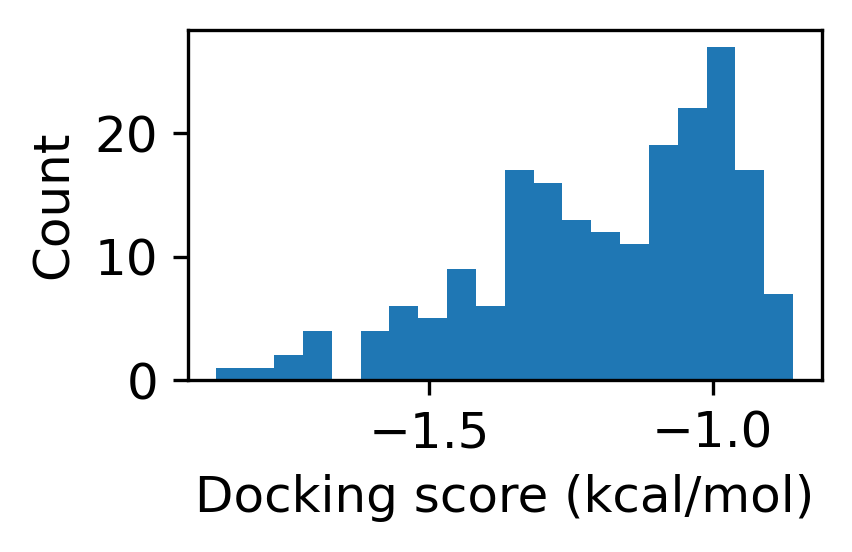

In [52]:
fig = plt.figure(figsize=(3,2))

plt.hist(v.energies(n_poses=n_poses)[:, 0], bins=20)
plt.xlabel("Docking score (kcal/mol)")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

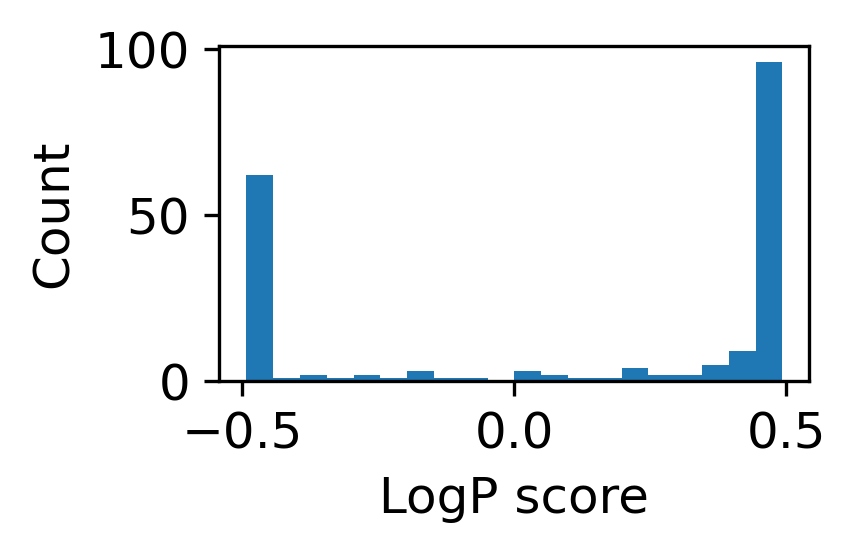

In [53]:
#Kucerka et al., 2008 Biophys. J. 95: 2356-2367
#https://dx.doi.org/10.1529%2Fbiophysj.108.132662
import math
scores = []
for pdb_file in sorted(glob.glob('./result_pdb/ligand_*.pdb'), key = lambda x: int(x.replace("./result_pdb/ligand_","").replace(".pdb",""))):
    pose = Chem.MolFromPDBFile(pdb_file)
    coordinates = [a for a in pose.GetConformers()[0].GetPositions()]
    score = []
    for coor, cont in zip(coordinates, contribs):
        if membrane_pos + buffer <= coor[2]:
            score.append(-1 *cont[0])
        elif membrane_pos - buffer < coor[2] and coor[2] < membrane_pos + buffer:
            sigmoid = -(2/ (1 + math.e**-( coor[2]-membrane_pos)))+1
            score.append(sigmoid *cont[0])
        elif -membrane_pos + buffer <= coor[2] and coor[2] <= membrane_pos - buffer:
            score.append(cont[0])
        elif -membrane_pos - buffer < coor[2] and coor[2] < -membrane_pos + buffer:
            sigmoid = (2 / (1 + math.e**-( coor[2]+membrane_pos)))-1
            score.append(sigmoid *cont[0])
        elif coor[2] <= -membrane_pos - buffer:
            score.append(-1 *cont[0])
    scores.append(sum(score))
fig = plt.figure(figsize=(3,2))

plt.hist(scores, bins=20)
plt.xlabel("LogP score")
plt.ylabel("Count")
plt.tight_layout()

plt.show()
#[print(i, s) for i,s in enumerate(scores)]
np.savetxt("logp_score.txt", scores)

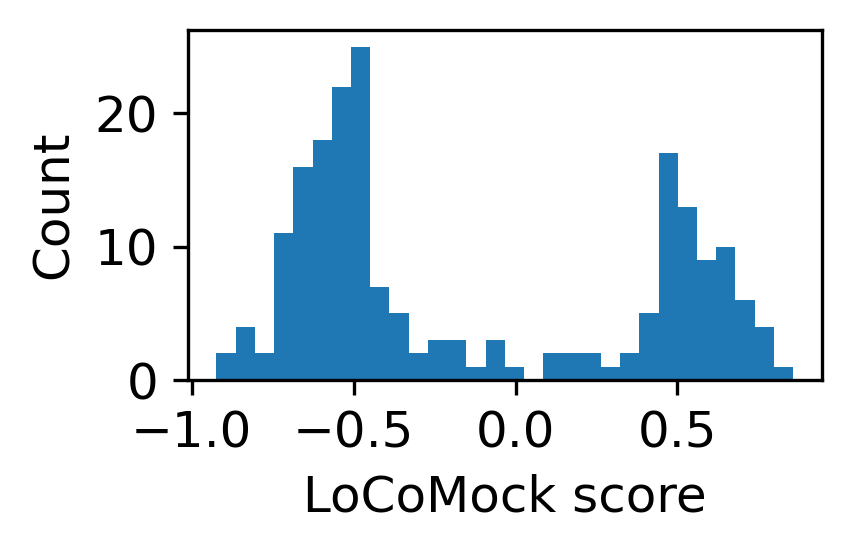

[(0, -0.924), (1, -0.8988672000000001), (4, -0.845152), (6, -0.832832), (5, -0.8183924527908767), (3, -0.8135961480130113), (9, -0.7978432), (10, -0.7919296), (19, -0.7446208), (13, -0.7367577743026351)]
[(32, 0.6889344), (31, 0.6992832), (28, 0.7042112), (21, 0.7258944), (14, 0.734767683942481), (16, 0.7520128), (15, 0.7559552), (12, 0.7692608), (8, 0.7978432), (2, 0.857472)]


In [54]:
multiple_score = [v[0]*logp for v, logp in zip(v.energies(n_poses=n_poses), scores)]
fig = plt.figure(figsize=(3,2))
plt.hist(multiple_score, bins=30)
plt.xlabel("LoCoMock score")
plt.ylabel("Count")
plt.tight_layout()

plt.show()

np.savetxt("locomock_score.txt", multiple_score)

print(sorted(enumerate(multiple_score), key=lambda x: x[1])[:10])
print(sorted(enumerate(multiple_score), key=lambda x: x[1])[-10:])

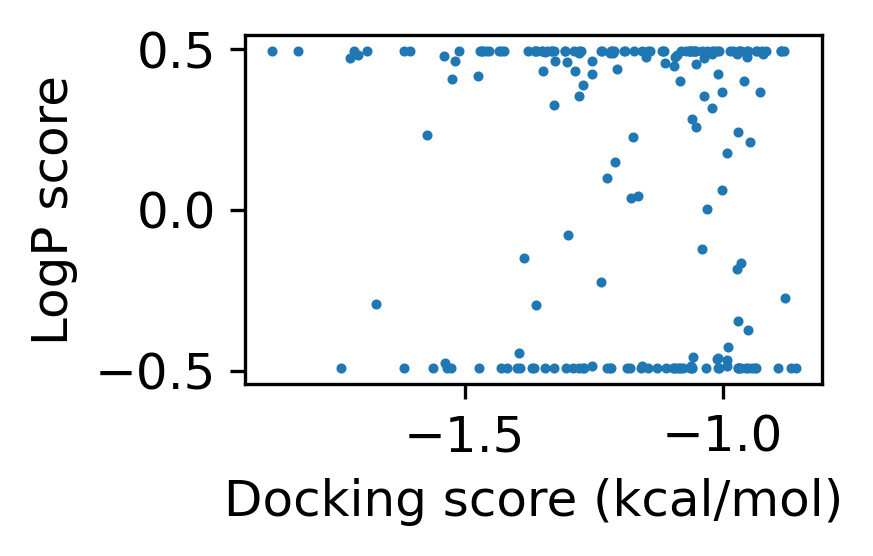

In [55]:
fig = plt.figure(figsize=(3,2))
plt.scatter(v.energies(n_poses=n_poses)[:, 0], scores, s=2)
plt.xlabel("Docking score (kcal/mol)")
plt.ylabel("LogP score")
plt.tight_layout()

plt.show()

In [56]:
 multiple_score = np.loadtxt("locomock_score.txt")

# All poses

In [57]:
view = py3Dmol.view()
view.removeAllModels()
view.setViewStyle({'style':'outline','color':'black','width':0.1})

view.addModel(open('protein_H.pdb','r').read(),format='pdb')
Prot=view.getModel()
Prot.setStyle({'cartoon':{'arrows':True, 'tubes':True, 'style':'oval', 'color':'white'}})
view.addSurface(py3Dmol.VDW,{'opacity':0.6,'color':'white'})

for i in sorted(enumerate(multiple_score), key=lambda x: x[1]):
    view.addModel(open(f"./result_pdb/ligand_{i[0]}.pdb",'r').read(),format='mol2')
    ref_m = view.getModel()
    ref_m.setStyle({},{'stick':{'colorscheme':'greenCarbon','radius':0.2}})

view.zoomTo()
view.show()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

# Best 10 poses

In [59]:
view = py3Dmol.view()
view.removeAllModels()
view.setViewStyle({'style':'outline','color':'black','width':0.1})

view.addModel(open('protein_H.pdb','r').read(),format='pdb')
Prot=view.getModel()
Prot.setStyle({'cartoon':{'arrows':True, 'tubes':True, 'style':'oval', 'color':'white'}})
view.addSurface(py3Dmol.VDW,{'opacity':0.6,'color':'white'})

for i in sorted(enumerate(multiple_score), key=lambda x: x[1])[:10]:
    view.addModel(open(f"./result_pdb/ligand_{i[0]}.pdb",'r').read(),format='mol2')
    ref_m = view.getModel()
    ref_m.setStyle({},{'stick':{'colorscheme':'greenCarbon','radius':0.2}})

view.zoomTo()
view.show()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

# Worst 10 poses

In [60]:
view = py3Dmol.view()
view.removeAllModels()
view.setViewStyle({'style':'outline','color':'black','width':0.1})

view.addModel(open('protein_H.pdb','r').read(),format='pdb')
Prot=view.getModel()
Prot.setStyle({'cartoon':{'arrows':True, 'tubes':True, 'style':'oval', 'color':'white'}})
view.addSurface(py3Dmol.VDW,{'opacity':0.6,'color':'white'})

for i in sorted(enumerate(multiple_score), key=lambda x: x[1])[-10:]:
    view.addModel(open(f"./result_pdb/ligand_{i[0]}.pdb",'r').read(),format='mol2')
    ref_m = view.getModel()
    ref_m.setStyle({},{'stick':{'colorscheme':'greenCarbon','radius':0.2}})

view.zoomTo()
view.show()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

# Export models

In [61]:
file_list = ""
for i in sorted(enumerate(multiple_score), key=lambda x: x[1]):
    file_list += f" ./result_pdb/ligand_{i[0]}.pdb"
!cat $file_list | sed -e "s/END/ENDMDL/g" > ./ligand_all.pdb

file_list = ""
for i in sorted(enumerate(multiple_score), key=lambda x: x[1])[:10]:
    file_list += f" ./result_pdb/ligand_{i[0]}.pdb"
!cat $file_list | sed -e "s/END/ENDMDL/g" > ./ligand_best10.pdb

file_list = ""
for i in sorted(enumerate(multiple_score), key=lambda x: x[1])[-10:]:
    file_list += f" ./result_pdb/ligand_{i[0]}.pdb"
!cat $file_list | sed -e "s/END/ENDMDL/g" > ./ligand_worst10.pdb

In [62]:
file_list = ""
best_100_list = []
for i in sorted(enumerate(multiple_score), key=lambda x: x[1])[:100]:
    file_list += f" ./result_pdb/ligand_{i[0]}.pdb"
    best_100_list.append(i[0])
!cat $file_list | sed -e "s/END/ENDMDL/g" > ./ligand_best100.pdb

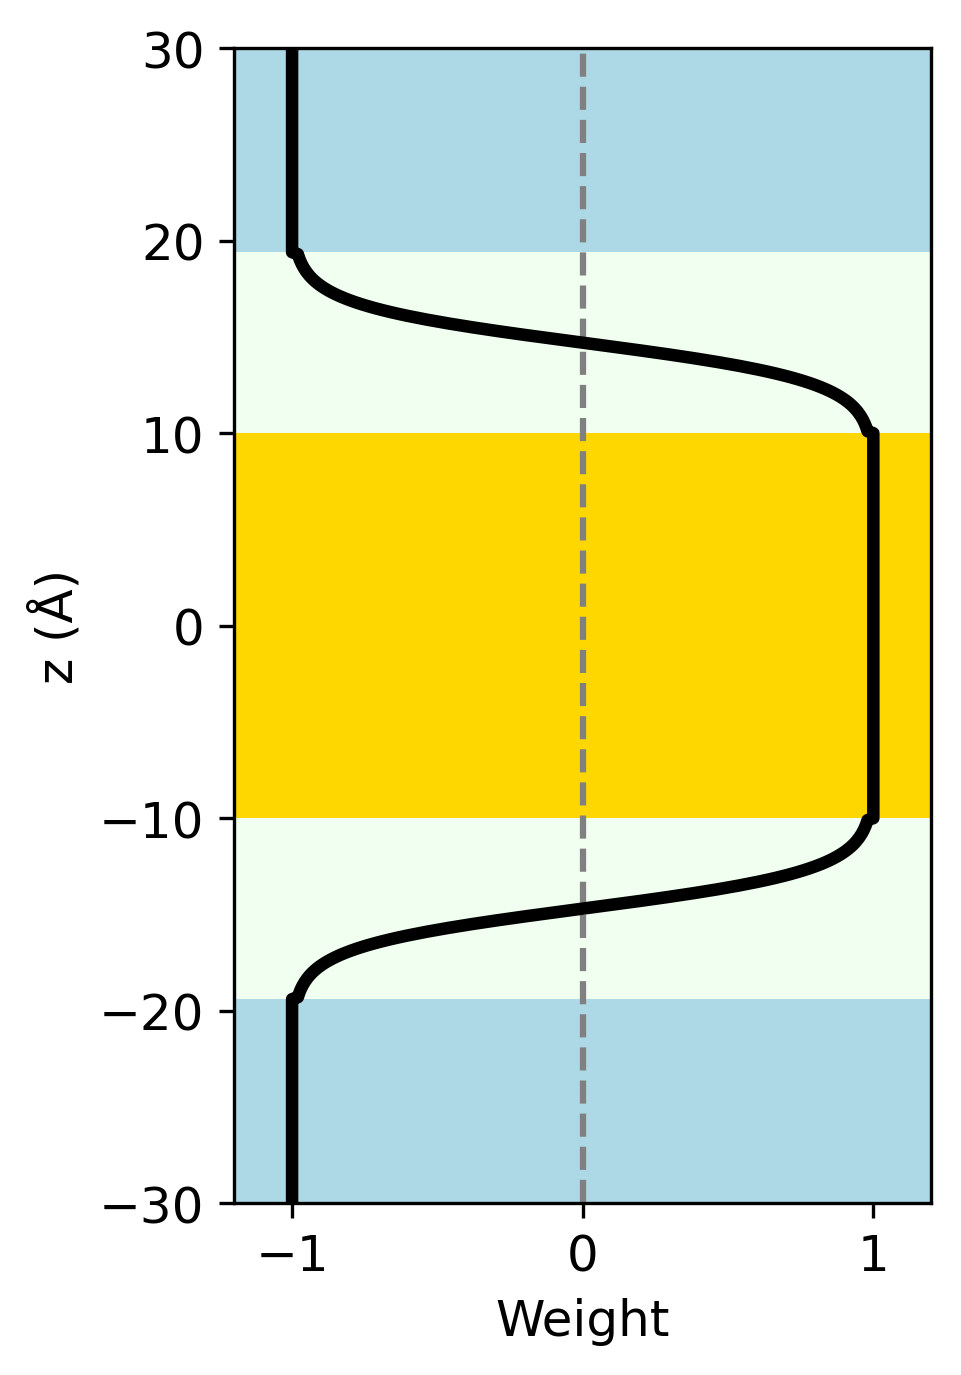

In [63]:
lines = []
for xi in [x/10 for x in range(-300,300)]:
    if membrane_pos + buffer <= xi:
        lines.append([xi,-1])
    elif membrane_pos - buffer < xi and xi < membrane_pos + buffer:
        sigmoid = -(2/ (1 + math.e**-(xi-membrane_pos)))+1
        lines.append([xi,sigmoid])
    elif -membrane_pos + buffer <= xi and xi <= membrane_pos - buffer:
        lines.append([xi,1])
    elif -membrane_pos - buffer < xi and xi < -membrane_pos + buffer:
        sigmoid = (2 / (1 + math.e**-(xi+membrane_pos)))-1
        lines.append([xi,sigmoid]) 
    elif xi <= -membrane_pos - buffer:
        lines.append([xi,-1])
fig = plt.figure(figsize=(3,5))
plt.plot([x[1] for x in lines], [x[0] for x in lines], color="black", zorder=999, lw=3)
plt.gca().axvline(0, linestyle="dashed", color="gray")
# plt.gca().axhline(membrane_pos + buffer, linestyle="solid", color="gray")
# plt.gca().axhline(membrane_pos, linestyle="solid", color="gray", lw=0.5)
# plt.gca().axhline(membrane_pos - buffer, linestyle="solid", color="gray")
# plt.gca().axhline(-membrane_pos + buffer, linestyle="solid", color="gray")
# plt.gca().axhline(-membrane_pos, linestyle="solid", color="gray")
# plt.gca().axhline(-membrane_pos - buffer, linestyle="solid", color="gray")
plt.gca().axhspan(membrane_pos + buffer, 30, facecolor="lightblue", alpha=1)
plt.gca().axhspan(membrane_pos - buffer, membrane_pos + buffer, facecolor="honeydew", alpha=1)
plt.gca().axhspan(-membrane_pos + buffer, membrane_pos - buffer, facecolor="gold", alpha=1)
plt.gca().axhspan(-membrane_pos - buffer, -membrane_pos + buffer, facecolor="honeydew", alpha=1)
plt.gca().axhspan(-30, -membrane_pos - buffer, facecolor="lightblue", alpha=1)

plt.xticks(range(-1,2))
plt.xlim(-1.2,1.2)
plt.ylim(-30,30)
plt.xlabel("Weight")
plt.ylabel("z (Å)")
plt.savefig("layer.png", dpi=300)
plt.show()